## 对抗样本的鲁棒性和可迁移性问题

### 1、鲁棒性问题
对抗扰动十分敏感，让对抗样本受到图像压缩、噪声、resize等变换时，会失效

In [1]:
import torch
import torchvision
from net.advGenerator import ResnetGenerator
from tarmodel.AutoEncoder import Generator
from utils.data_loader import get_loader
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 加载扰动生成器
advG = ResnetGenerator(input_nc=3).to(device)
advG.load_state_dict(torch.load('checkpoints/adv_gen.pth'))
advG.eval()

# 加载目标AE模型
model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/AE_celeba.pth'))
model.eval()

Generator(
  (en_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01

Finished preprocessing the CelebA dataset...


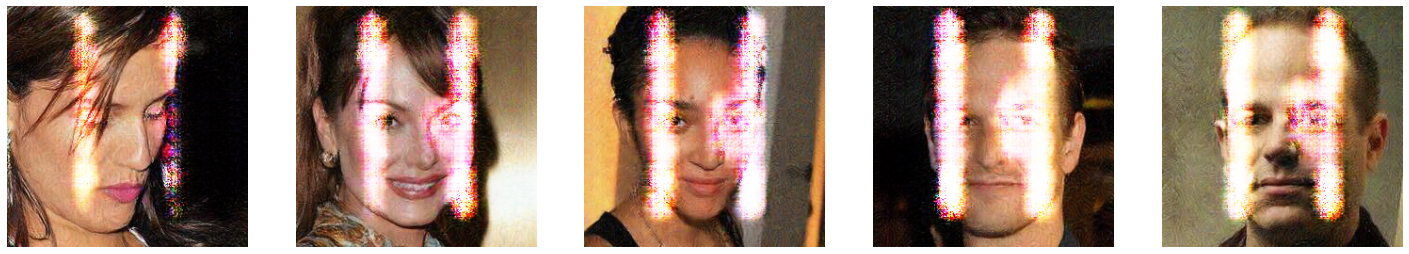

In [2]:
import matplotlib.pyplot as plt
from utils.utils import denorm

# 读取测试数据
testloader = get_loader("dataset/celeba/images", "dataset/celeba/list.txt", ['Black_Hair'], image_size=256, batch_size=5, mode="test", num_workers=1)

# 3. 获取一批图像和标签
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


# 生成对抗扰动
epsilon = 0.05
perturbation = advG(images)
perturbation = torch.clamp(perturbation, -epsilon, epsilon)
adv_images = torch.clamp(images + perturbation, -1.0, 1.0)

# 攻击AE
output = model(adv_images)


# 绘制图像
fig, axes = plt.subplots(1, 5, figsize=(25, 20)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # 显示攻击结果
    axes[i].imshow(attack_res)
    axes[i].axis('off')

plt.show()

In [3]:
import cv2
import torch
import numpy as np
from utils.utils import Image2tensor, denorm
from torchvision.utils import save_image

# 假设 adv_images 是一个 (5, 3, 256, 256) 的张量
batch_size = adv_images.size(0)

# 逐张图像处理
com_adv_images_list = []
for i in range(batch_size):
    # 保存单张图像
    save_image(denorm(adv_images[i]).data.cpu(), f"images/temp.png")
    img = cv2.imread(f"images/temp.png")
    cv2.imwrite(f"images/com.jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 50])
    
    # 将JPEG压缩后的图像转换回tensor并存入列表
    com_adv_images_list.append(Image2tensor(f"images/com.jpg")[0])

# 将所有的处理后图像合并为一个tensor
com_adv_images = torch.stack(com_adv_images_list)

# 攻击AE
output2 = model(com_adv_images)

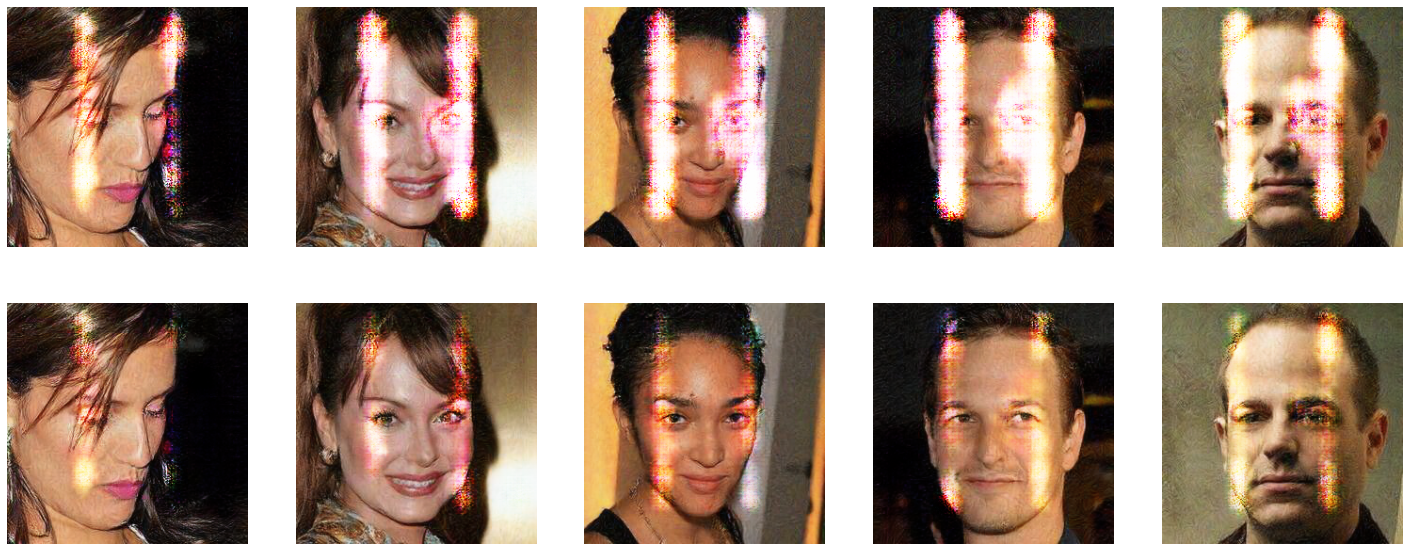

In [4]:
# 绘制图像
fig, axes = plt.subplots(2, 5, figsize=(25, 10)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    attack_res_com = denorm(output2)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # 显示攻击结果
    axes[0, i].imshow(attack_res)
    axes[0, i].axis('off')

    axes[1, i].imshow(attack_res_com)
    axes[1, i].axis('off')

plt.show()

### 可迁移性
白盒的对抗扰动需要对模型的参数、结构已知，所以具有针对性，这就造成了较差的可迁移性，即对A模型求得的扰动往往无法有效攻击B模型

In [5]:
import torch
import torchvision
from net.advGenerator import ResnetGenerator
from tarmodel.AutoEncoder import Generator
from tarmodel.AutoEncoder2 import Generator as Generator2
from utils.data_loader import get_loader
# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 加载扰动生成器
advG = ResnetGenerator(input_nc=3).to(device)
advG.load_state_dict(torch.load('checkpoints/adv_gen.pth'))
advG.eval()

# 加载目标AE模型
model = Generator().to(device)
model.load_state_dict(torch.load('checkpoints/AE_celeba.pth'))
model.eval()

# 加载目黑盒E模型
model2 = Generator2().to(device)
model2.load_state_dict(torch.load('checkpoints/AE2_celeba.pth'))
model2.eval()

Generator(
  (en_layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (en_layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (Residual): Sequential(
    (0): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

Finished preprocessing the CelebA dataset...


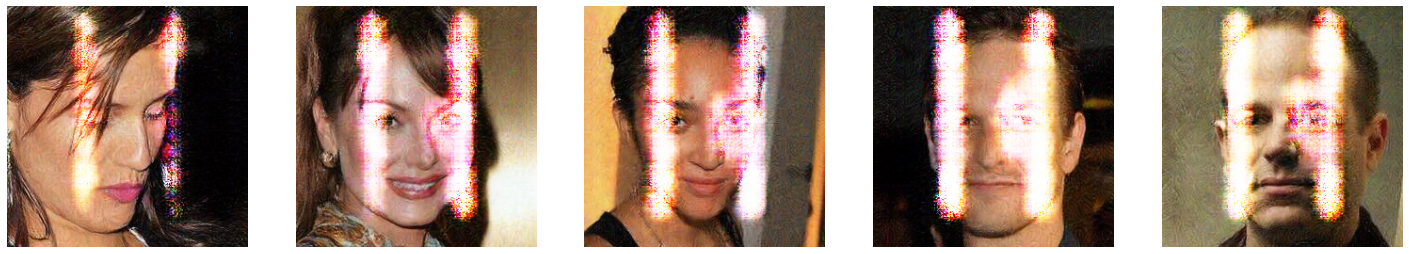

In [6]:
import matplotlib.pyplot as plt
from utils.utils import denorm

# 读取测试数据
testloader = get_loader("dataset/celeba/images", "dataset/celeba/list.txt", ['Black_Hair'], image_size=256, batch_size=5, mode="test", num_workers=1)

# 3. 获取一批图像和标签
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


# 生成对抗扰动
epsilon = 0.05
perturbation = advG(images)
perturbation = torch.clamp(perturbation, -epsilon, epsilon)
adv_images = torch.clamp(images + perturbation, -1.0, 1.0)

# 攻击AE
output = model(adv_images)


# 绘制图像
fig, axes = plt.subplots(1, 5, figsize=(25, 20)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # 显示攻击结果
    axes[i].imshow(attack_res)
    axes[i].axis('off')

plt.show()

In [7]:
import cv2
import torch
import numpy as np
from utils.utils import Image2tensor, denorm
from torchvision.utils import save_image

# 攻击黑盒AE
output2 = model2(adv_images)

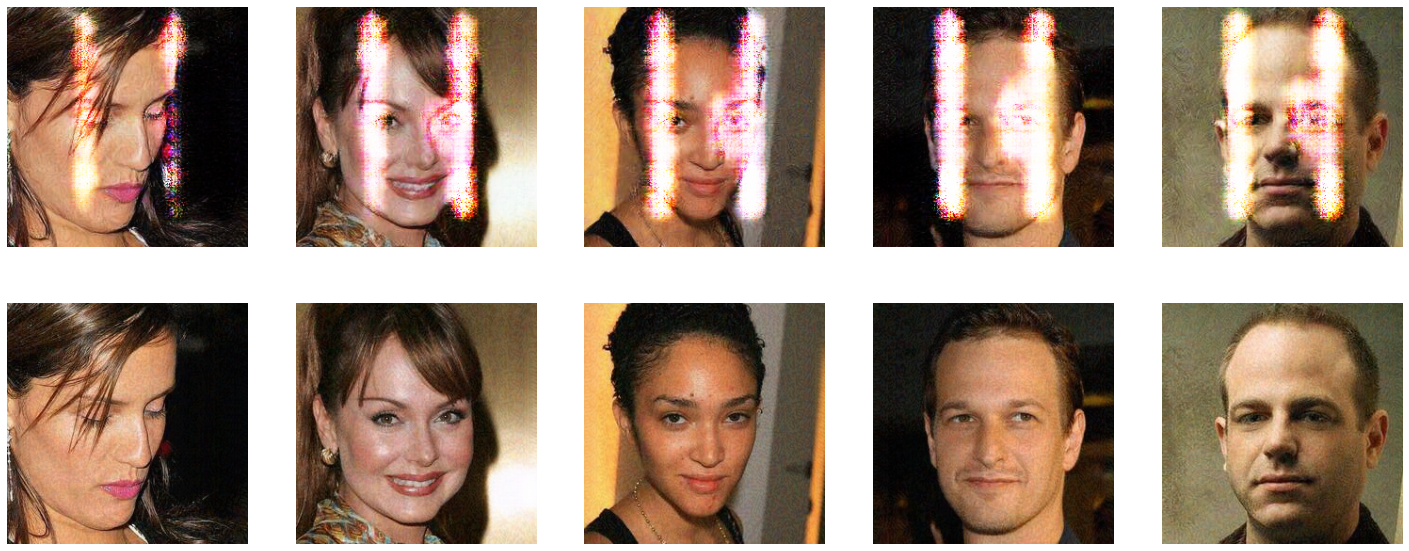

In [8]:
# 绘制图像
fig, axes = plt.subplots(2, 5, figsize=(25, 10)) 

for i in range(5):
    # 将图像从 tensor 转为 numpy 格式，转置为 (H, W, C)
    attack_res = denorm(output)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    attack_res_com = denorm(output2)[i].detach().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # 显示攻击结果
    axes[0, i].imshow(attack_res)
    axes[0, i].axis('off')

    axes[1, i].imshow(attack_res_com)
    axes[1, i].axis('off')

plt.show()